### Preprocessing

In [27]:
# import relevant statistical packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
# import relevant data visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Generating a response $Y$ with two predictors $X1$ and $X2$, with $n$=100

In [3]:
X1 = np.random.normal(size=100)
X2 = np.random.normal(size=100)
epsilon = np.random.normal(scale=2.5, size=100)
Y = -12.5 + 35.7*X1 - 23.4*X2 + epsilon

### Generating $\hat{\beta}$

In [4]:
beta1 = 25.7

### Keeping $\hat{\beta}$ and fitting the model, $Y - \hat{\beta_1}X_1 = \beta_0 + \beta_2X_2 + \epsilon$

In [5]:
a2 = Y - beta1*X1

In [6]:
lm2 = LinearRegression(fit_intercept=True).fit(X2.reshape(-1, 1), a2)
beta2 = lm2.coef_[0]

### Keeping $\hat{\beta_2}$ fixed and fitting the model, $Y - \hat{\beta_2}X_2 = \beta_0 + \beta_1X_1 + \epsilon$

In [7]:
a1 = Y - beta2*X2

In [8]:
lm1 = LinearRegression(fit_intercept=True).fit(X1.reshape(-1, 1), a1)
beta1 = lm1.coef_[0]

In [9]:
lm1.intercept_, lm2.intercept_

(-12.556917517501297, -10.911724776950956)

In [10]:
beta1, beta2

(35.578599341267214, -24.03447727121168)

### Estimating $\hat{\beta_0}$, $\hat{\beta_1}$ and $\hat{\beta_2}$ with $n$=100 iterations instead of 1,000

In [19]:
n = 100
beta0 = np.zeros(n)
beta1 = np.zeros(n)
beta2 = np.zeros(n)

In [20]:
beta1[0] = 25.7
for k in range(0, n):
    a2 = Y - beta1[k]*X1
    lm2 = LinearRegression(fit_intercept=True).fit(X2.reshape(-1, 1), a2)
    beta2[k] = lm2.coef_[0]
    a1 = Y - beta2[k]*X2
    lm1 = LinearRegression(fit_intercept=True).fit(X1.reshape(-1, 1), a1)
    if k<n-1:
        beta1[k+1] = lm1.coef_[0]
    beta0[k] = lm1.intercept_

In [21]:
betadf = pd.concat([pd.DataFrame(beta0), pd.DataFrame(beta1), pd.DataFrame(beta2)], axis=1)
betadf.columns = ['beta0', 'beta1', 'beta2']
betadf.head()

,beta0,beta1,beta2
0,-12.556918,25.700000,-24.034477
1,-12.653501,35.578599,-23.190062
2,-12.654152,35.645221,-23.184368
3,-12.654157,35.645670,-23.184329
4,-12.654157,35.645673,-23.184329


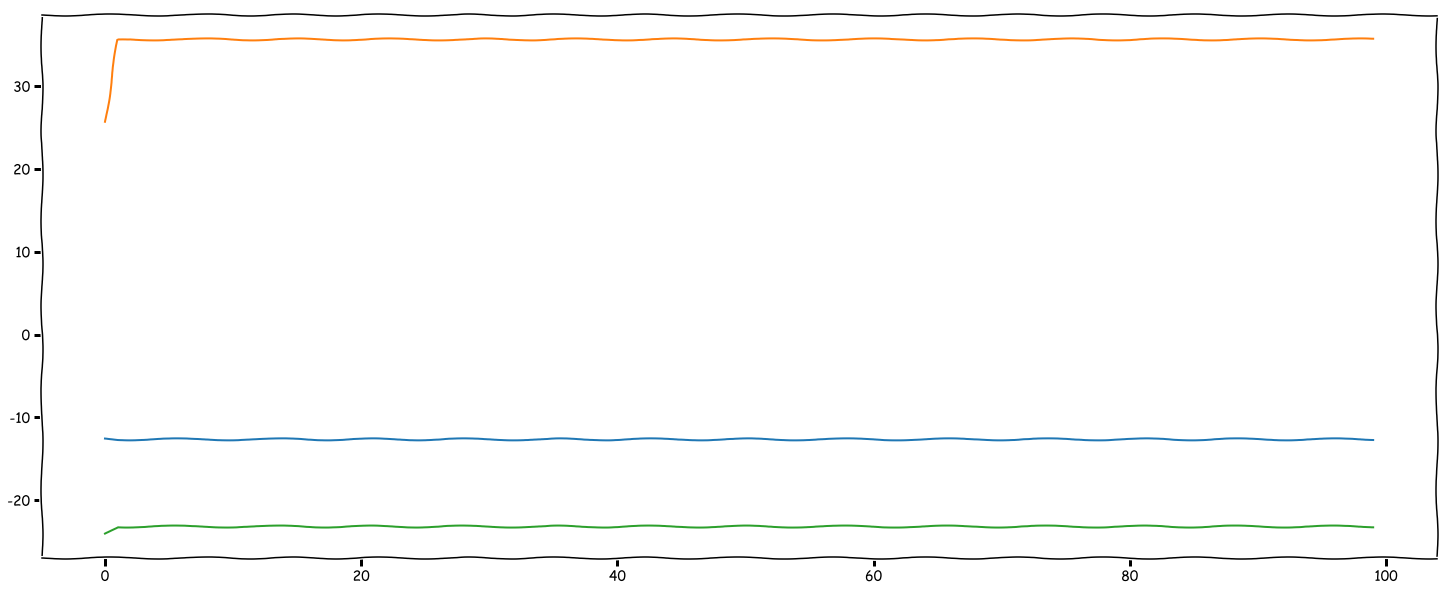

In [22]:
plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(betadf)

**The coefficients attaing their least square values quite quickly.**

### Performing multiple linear regression tp predict $Y$ using $X1$ and $X2$

In [23]:
df = pd.concat([pd.DataFrame(Y), pd.DataFrame(X1), pd.DataFrame(X2)], axis=1)
df.columns = ['Y', 'X1', 'X2']
df.head()

,Y,X1,X2
0,-17.034345,0.286012,0.744432
1,99.956508,1.801501,-1.736967
2,-17.205472,-0.017482,0.253826
3,-41.052872,-0.215606,0.845757
4,-41.271943,0.657296,2.233010


In [24]:
lmreg = LinearRegression().fit(df[['X1', 'X2']], df['Y'])
coef = pd.DataFrame([lmreg.coef_])
intercept = pd.DataFrame([lmreg.intercept_])

In [25]:
allval = pd.concat([intercept, coef], axis=1)
allval.columns = ['beta0', 'beta1', 'beta2']
allval

,beta0,beta1,beta2
0,-12.654157,35.645673,-23.184329


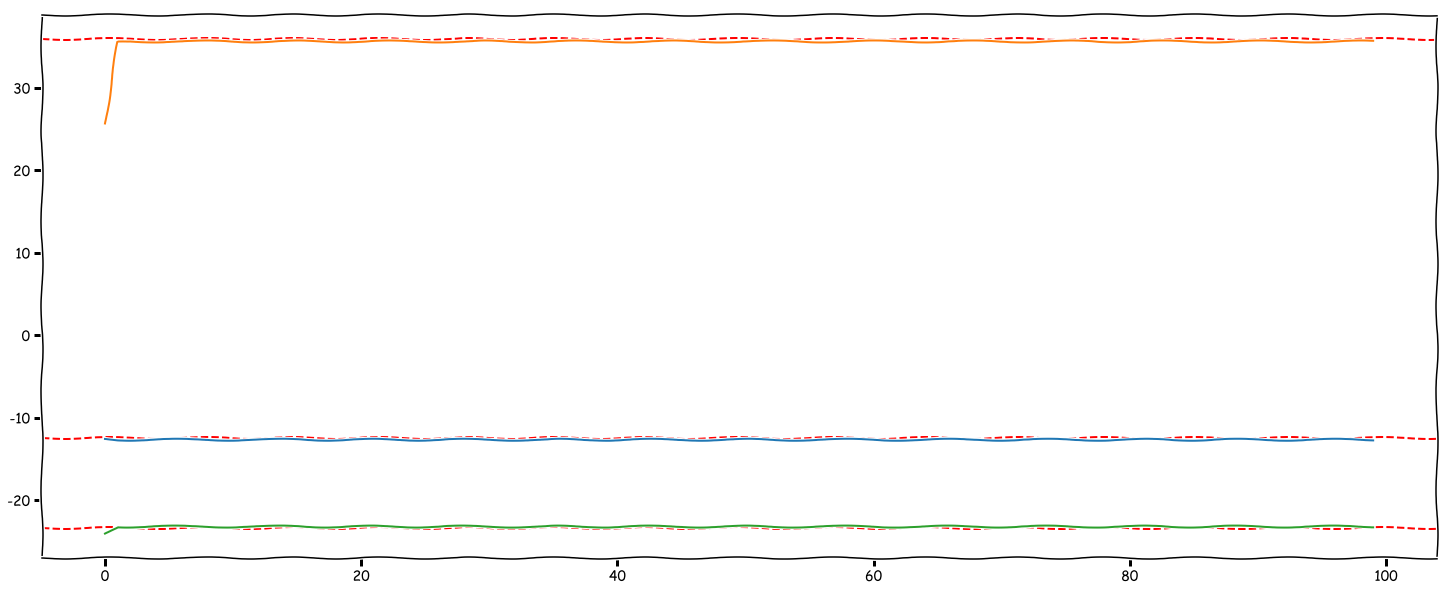

In [33]:
plt.xkcd()
plt.figure(figsize=(25, 10))
[plt.axhline(k , 0, 1000, lw=2, linestyle='--', c='r') for k in [-12.474106, 35.896213, -23.297124]]
plt.plot(betadf)

**So, we can see that *backfitting* provides similar estimates for coefficient values as that of performing multiple linear regression even with 100 values and we don't really need to perform any more iterations. The questions then is:  what is the optimal number of iterations required to obtain a "good" approximation to the multiple coefficient regression estimates?**

### Performing cross-validation to obtain the optimal value of $n$

**Calculating MSE of multiple linear regression**

In [34]:
from sklearn.metrics import mean_squared_error

In [79]:
mlr_err = mean_squared_error(df['Y'], lmreg.predict(df[['X1', 'X2']]))
mlr_err

6.723275168628422

In [80]:
n = 1000
beta0 = np.zeros(n)
beta1 = np.zeros(n)
beta2 = np.zeros(n)

In [93]:
beta1[0] = 25.7
errdf = pd.DataFrame()
testdf = pd.DataFrame()
for k in range(0, n):
    a2 = Y - beta1[k]*X1
    lm2 = LinearRegression(fit_intercept=True).fit(X2.reshape(-1, 1), a2)
    beta2[k] = lm2.coef_[0]
    a1 = Y - beta2[k]*X2
    lm1 = LinearRegression(fit_intercept=True).fit(X1.reshape(-1, 1), a1)
    if k<n-1:
        beta1[k+1] = lm1.coef_[0]
    beta0[k] = lm1.intercept_
    testdf = pd.concat([pd.DataFrame([beta0[k]]), pd.DataFrame([beta1[k]]), pd.DataFrame([beta2[k]])], axis=1)
    testdf.columns = ['beta0', 'beta1', 'beta2']
    err = mean_squared_error(df['Y'], (beta0[k] + beta1[k]*X1 + beta2[k]*X2))
    errdf = errdf.append(pd.DataFrame([pow(mlr_err-err, 2)]))
errdf.reset_index(drop=True, inplace=True)
errdf.columns = ['err']
errdf.head(10)

,err
0,8.886980e+03
1,1.838383e-05
2,3.802925e-14
3,7.863386e-23
4,7.099748e-30
5,0.000000e+00
6,7.099748e-30
7,7.099748e-30
8,7.099748e-30
9,7.099748e-30


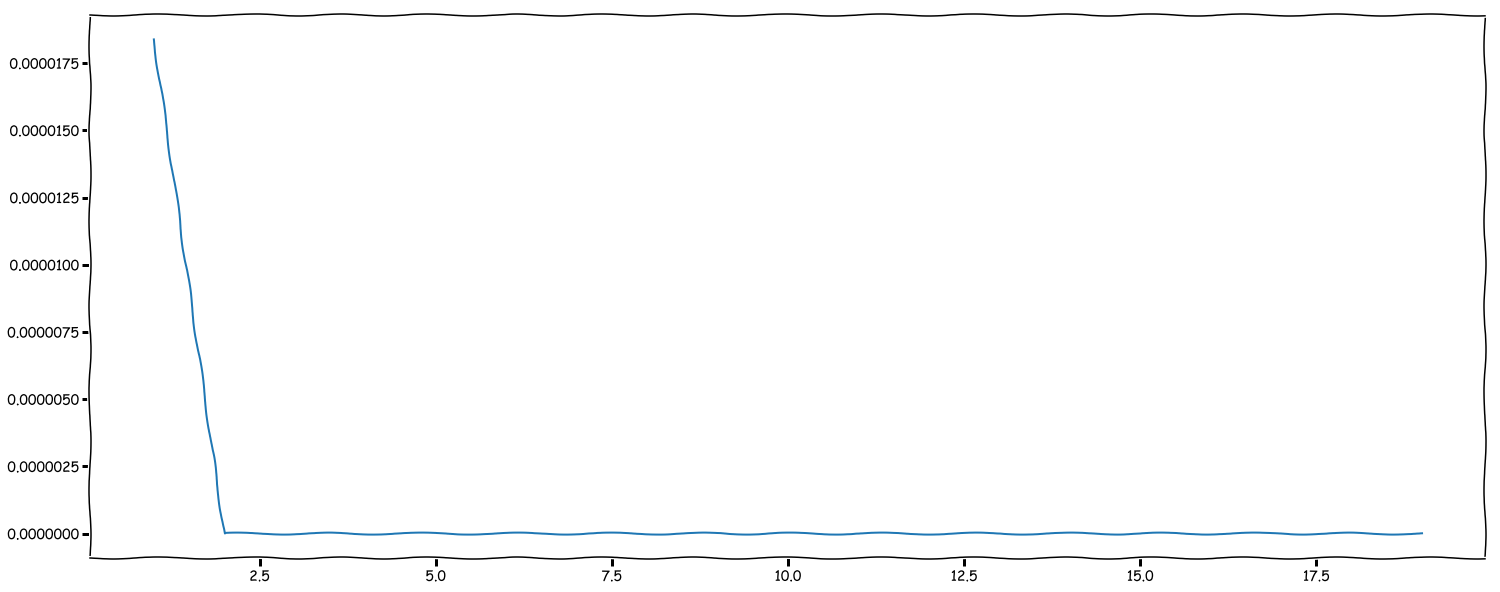

In [100]:
plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(errdf.iloc[1:20])

**I notice that the error drops to ~0 at $n$=2 and remains mostly stable thereafter. Therefore, I can conclude that $n$=2 is the optimal number of iterations "good" approximations of cofficients that have been estimated using  multiple linear regression.**